In [39]:
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
from functions.generate import get_generator, generate_time_series

In [40]:
t = 300 # days
changepoints = 20 # number of chamngepoints 
fourier_series_n = 10 # number of fourier series folds
k = 1 # growth rate
m = 0 # offset parameter
P = 7 # parameter for fourier series 7 - weekly, 365 - yearly ...
D = 5 # specific holidays

In [41]:
key = jax.random.PRNGKey(2137)
_, A = get_generator(max_length=t, max_fourier_order=fourier_series_n,max_period_number=1)
Y, w = generate_time_series(key, A, batch_size=3)

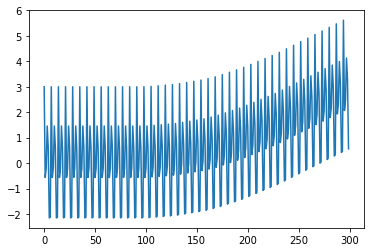

In [42]:
plt.plot(list(range(t)), list(Y[2]))
plt.show()

### Trend

In [43]:
def get_changepoint_matrix(T, S):
    step = T/(S+1)
    s = jnp.arange(start=0, stop=T, step=step).astype(int)[1:]
    f = jax.vmap(lambda x: jnp.where(jnp.arange(T) >= x, jnp.ones(T), jnp.zeros(T)), 0, 0)
    A = f(s).T
    return A, s

In [44]:
def get_trend(params, T, A, s):
    k, m, ro = params["k"], params["m"], params["ro"]
    k /= T.shape[0]
    A /= T.shape[0]
    trend = (k+A@ro)*T + (m - A@(s*ro))
    return trend

### Seasonality

In [45]:
def get_seasonality(params, T, P, N):
    n = jnp.arange(N)
    t = jax.numpy.expand_dims(T, 1)
    fraction = 2 * np.pi / P * n
    fraction = t * fraction 
    sins = jax.numpy.sin(fraction) 
    coss = jax.numpy.cos(fraction) 
    fourier = jax.numpy.concatenate((sins,coss), axis=1)
    beta = params["beta"]
    seasonality = jax.numpy.sum(fourier * beta, axis=1)
    return seasonality

### Holidays

In [46]:
def get_holidays(params, T, D, seed=420):
    holidays_matrix = jnp.zeros((T.shape[0],D))
    np.random.seed(seed)
    for i in range(D-1):
        indexes = np.random.choice(np.arange(t), np.random.randint(t*0.05,t*0.2))
        holidays_matrix = holidays_matrix.at[indexes, i].set(1)
    indexes = np.arange(0,t,7,dtype=int)
    holidays_matrix = holidays_matrix.at[indexes, D-1].set(1)
    kappa = params["kappa"]
    holidays = jax.numpy.sum(holidays_matrix * kappa, axis=1)
    return holidays

### Results

In [47]:
import jax.numpy as jnp
import jax
def loss_linear(params, X, Y, A,s):
    return jnp.mean((model_linear(params,X,A,s)-Y)**2)
def model_linear(params, X, A,s):
    trend = get_trend(params, X, A, s)
    seasonality = get_seasonality(params, X, P, fourier_series_n)
    holidays = get_holidays(params, X, D)
    #print(trend.shape)
    #print(seasonality.shape)
    #rint((trend+seasonality+holidays).shape)
    return seasonality+holidays+trend
#@jax.jit
def update_linear(X, Y, params, lr, A, s):
    loss, grads = jax.value_and_grad(loss_linear)(params,X,Y,A,s)
    #print(loss)
    new_params = jax.tree_multimap(lambda p, g: p - lr*g, params, grads)
    return new_params, loss
def fit_linear_prophet(X, Y, lr, epochs, A,s):
    params = {}
    params["k"] = jnp.ones((1,)) * 0.1
    params["m"] = jnp.ones((1,)) * 0.1
    params["ro"] = jnp.ones((A.shape[1],)) * 0.1
    params["beta"] = jnp.ones((2*fourier_series_n,)) * 0.1
    params["kappa"] = jnp.ones((D,)) * 0.1
    for i in range(epochs):
        params, loss = update_linear(X,Y,params,lr,A,s)
    #print(loss)
    return params
def infer_linear_prophet(X, params, A,s):
    return model_linear(params,X,A,s)
    
def get_changepoint_matrix_predict(T_old, T_new, params, S):
    lmbd = jnp.sum(params["ro"])/S
    step = T_new/(S+1)
    s = jnp.arange(start=T_old, stop=T_old+T_new, step=step).astype(int)[1:]
    f = jax.vmap(lambda x: jnp.where(jnp.arange(T_new) >= x, lmbd, jnp.zeros(T_new)), 0, 0)
    A = f(s).T
    return A, s

def prophet_predict(X_old, X_new, params, changepoints):
    T_old = len(X_old)
    T_new = len(X_new)
    A, s = get_changepoint_matrix_predict(T_old, T_new, params,changepoints)
    model = model_linear(params, X_new, A, s)
    return model

In [48]:
A, s = get_changepoint_matrix(t, changepoints)
prophet = fit_linear_prophet(jnp.arange(t), Y[0], 0.005, 1000, A, s)

In [49]:
new_y = prophet_predict(jnp.arange(300),jnp.arange(100), prophet, changepoints)

In [54]:
new_y * jnp.arange(300, 400)

DeviceArray([-20.345856  , -17.8384    , -19.773443  ,  -9.843285  ,
             -10.191502  ,  -6.1666517 , -17.06198   , -17.569021  ,
               4.370487  ,   2.4651968 ,  -6.787514  , -14.549861  ,
             -13.821169  , -14.1372595 , -14.6439085 ,  -4.4829698 ,
             -13.996722  , -11.144169  , -11.509844  , -10.752471  ,
             -11.06427   , -11.570237  ,  -8.851904  ,   0.31232888,
              -7.9590783 ,  -8.321066  ,   0.23916605,   4.9140344 ,
               3.0230238 ,  -5.5604124 ,   5.2472167 ,   9.033255  ,
              -4.984157  ,  -4.170857  ,  -4.4735446 ,  -4.9784894 ,
              -2.1201053 ,  22.833862  ,  -1.1433644 ,  -1.498614  ,
              -0.65763956,  -0.9562872 ,  -1.460063  ,   1.4685974 ,
              -0.66334665,   2.4864235 ,   2.1339593 ,  17.322699  ,
               2.7097425 ,   2.205901  ,   5.2054214 ,  16.733212  ,
              19.997242  ,   5.915333  ,  20.62395   ,   6.524411  ,
               6.020653  ,   9.090

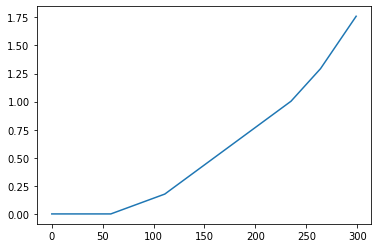

In [57]:
plt.plot(jnp.arange(300),Y[0])

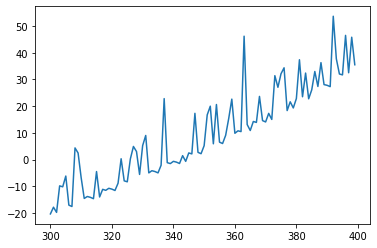

In [59]:
plt.plot(jnp.arange(300,400),new_y*jnp.arange(300,400))
plt.show()